# Progression Analysis

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
from datetime import date
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../load_data')
from load import load_stats, load_history

pd.options.mode.chained_assignment = None

## Load Data

In [2]:
players = load_stats()
history = load_history()

## Functions

In [3]:
def zero_to_x_time(player, minrating):
    try:
        r_hist = history[history['USATT#'] == player['USATT#']]
        over = r_hist[r_hist['Final Rating'] >= minrating]
        return (over.loc(axis=0)[over.index[-1], 'Start Date'] - r_hist.loc(axis=0)[r_hist.index[-1], 'Start Date']).days
    except IndexError:
        return pd.NA
    
def x_to_x_time(player, x1, x2):
    e_r_hist = history[history['USATT#'] == player['USATT#']]

    if x1 > x2:
        raise ValueError('Initial Rating must be lower than Final Rating')
    if e_r_hist[e_r_hist['Final Rating'] > x1].empty or e_r_hist[e_r_hist['Final Rating'] > x2].empty:
        return pd.NA
    
    x1index = e_r_hist[e_r_hist['Final Rating'] >= x1].index[-1]
    x2index = e_r_hist[e_r_hist['Final Rating'] >= x2].index[-1]
    r_hist = e_r_hist.loc[x2index:x1index]
    return (r_hist.loc[r_hist.index[0], 'Start Date'] - r_hist.loc[r_hist.index[-1], 'Start Date']).days

def age_by_x(player, r):
    r_hist = history[history['USATT#'] == player['USATT#']]
    scope = r_hist[r_hist['Final Rating'] > r]
    try:
        return (scope.loc[scope.index[-1], 'Start Date'] - player['Date of Birth']).days
    except IndexError:
        return pd.NaT

def is_top_junior(player, male_top_junior_rating, female_top_junior_rating):
    if player['Gender'] == 'M':
        age_by_rating = age_by_x(player, male_top_junior_rating)
    elif player['Gender'] == 'F':
        age_by_rating = age_by_x(player, female_top_junior_rating)
    else:
        return pd.NA
    
    if age_by_rating is pd.NaT:
        return False
    return age_by_rating < timedelta(days=19*365).days

def get_top_junior_stats(minrating, rating_male, rating_female):
    players['Top Junior Player'] = players.apply(is_top_junior, args=(rating_male, rating_female), axis=1)
    scope = players[(players[f'0-{minrating}'].notna()) & (players[f'0-{minrating}'] != 0)]
    top_juniors = scope[scope['Top Junior Player']]
    others = scope[scope['Top Junior Player'] == False]
    return [rating_male, rating_female, len(top_juniors), len(others), top_juniors[f'0-{minrating}'].mean(), others[f'0-{minrating}'].mean()]

def print_top_junior_stats(stats, minrating):
    print(f'Male Top Junior Min Rating: {stats[0]}')
    print(f'Female Top Junior Min Rating: {stats[1]}')
    print(f'Top Junior Count: {stats[2]}')
    print(f'Others Count: {stats[3]}')
    print(f'0-{minrating} avg num days:')
    print(f'Top Juniors: {stats[4]}')
    print(f'Everyone else: {stats[5]}')

## Test Functions

In [4]:
me = players[players['Database#'] == 102103].iloc[0]
me

Rank                                                       129
First Name                                             Stanley
Last Name                                                  Hsu
Database#                                               102103
USATT#                                                   97890
Location                                     North Potomac, MD
Home Club                 MDTTC - Maryland Table Tennis Center
Tournament Rating                                         2509
Last Played Tournament                     2024-08-25 00:00:00
League Rating                                             2186
Last Played League                         2020-02-07 00:00:00
Membership Expiration                                   ACTIVE
State                                                       MD
Zip                                                      20878
Gender                                                       M
Date of Birth                              2008-09-25 0

Zero to x rating time

In [5]:
print(f'Current max rating: {me['Max Rating']}')
print(f'Unrated: {zero_to_x_time(me, 0)} days')
print(f'Under current rating (2500): {zero_to_x_time(me, 2500)} days')
print(f'Above current rating (2700): {zero_to_x_time(me, 2700)} days')

Current max rating: 2519.0
Unrated: 0 days
Under current rating (2500): 3045 days
Above current rating (2700): <NA> days


x to x rating time

In [6]:
print(f'Current max rating: {me['Max Rating']}')
print(f'Unrated: {x_to_x_time(me, 0, 0)} days')
print(f'Under current rating (2000-2500): {x_to_x_time(me, 2000, 2500)} days')
print('try intial rating greater than final rating:')
try:
    print(f'{x_to_x_time(me, 3000, 2700)} days')
except ValueError:
    print('caught ValueError')

Current max rating: 2519.0
Unrated: 0 days
Under current rating (2000-2500): 2063 days
try intial rating greater than final rating:
caught ValueError


age by x

In [7]:
print(f'Current age: {me['Age'].days}')
print(f'Unrated: {age_by_x(me, 0)} days')
print(f'Under current rating (2500): {age_by_x(me, 2500)} days')
print(f'Above current rating (3000): {age_by_x(me, 3000)} days')

Current age: 5872
Unrated: 2585 days
Under current rating (2500): 5637 days
Above current rating (3000): NaT days


is top junior

In [8]:
print(f'Current age: {me['Age'].days}')
print(f'Gender: {me['Gender']}')
print(f'Age by 2500: {age_by_x(me, 2500)} days')
print(f'19 years in days: {timedelta(19*365).days}')
print(f'Is top junior (2500 cutoff): {is_top_junior(me, 2500, 2500)}')

Current age: 5872
Gender: M
Age by 2500: 5637 days
19 years in days: 6935
Is top junior (2500 cutoff): True


In [9]:
test_female = players[players['Database#'] == 9030].iloc[0]
print(f'Current age: {test_female['Age'].days}')
print(f'Gender: {test_female['Gender']}')
print(f'Age by 2500: {age_by_x(test_female, 2500)} days')
print(f'19 years in days: {timedelta(19*365).days}')
print(f'Is top junior (2500 cutoff): {is_top_junior(test_female, 2500, 2500)}')

Current age: 10356
Gender: F
Age by 2500: 5390 days
19 years in days: 6935
Is top junior (2500 cutoff): True


In [10]:
test_noob = players[players['Database#'] == 8196].iloc[0]
print(f'Current age: {test_noob['Age'].days}')
print(f'Gender: {test_noob['Gender']}')
print(f'Age by 2500: {age_by_x(test_noob, 2500)} days')
print(f'19 years in days: {timedelta(19*365).days}')
print(f'Is top junior (2500 cutoff): {is_top_junior(test_noob, 2500, 2500)}')

Current age: 28054
Gender: M
Age by 2500: NaT days
19 years in days: 6935
Is top junior (2500 cutoff): False


## 2200 Pace

In [11]:
minrating = 2200
players[f'0-{minrating}'] = players.apply(zero_to_x_time, args=(minrating,), axis=1)
players[f'Age by {minrating}'] = players.apply(age_by_x, args=(2200,), axis=1) # type: ignore
top_junior_stats = pd.DataFrame(columns=['Male Min Rating', 'Female Min Rating', 'Top Junior Count', 'Others Count', '0-2200 Top Juniors', '0-2200 Others'])

In [12]:
top_junior_stats.loc[len(top_junior_stats)] = get_top_junior_stats(minrating, 2500, 2500)

In [13]:
top_junior_stats.loc[len(top_junior_stats)] = get_top_junior_stats(minrating, 2500, 2300)

In [14]:
top_junior_stats.loc[len(top_junior_stats)] = get_top_junior_stats(minrating, 2500, 2200)

In [15]:
top_junior_stats.loc[len(top_junior_stats)] = get_top_junior_stats(minrating, 2400, 2200)

In [16]:
top_junior_stats.loc[len(top_junior_stats)] = get_top_junior_stats(minrating, 2300, 2200)

In [17]:
top_junior_stats.loc[len(top_junior_stats)] = get_top_junior_stats(minrating, 2200, 2200)

In [18]:
top_junior_stats.loc[len(top_junior_stats)] = get_top_junior_stats(minrating, 2250, 2200)

## Data

In [19]:
top_junior_stats['0-2200 Difference'] = top_junior_stats['0-2200 Others'] - top_junior_stats['0-2200 Top Juniors']
top_junior_stats

,Male Min Rating,Female Min Rating,Top Junior Count,Others Count,0-2200 Top Juniors,0-2200 Others,0-2200 Difference
0,2500.0,2500.0,38.0,470.0,1334.184211,1957.744681,623.560470
1,2500.0,2300.0,62.0,446.0,1531.225806,1963.908072,432.682265
2,2500.0,2200.0,91.0,417.0,1605.824176,1977.719424,371.895249
3,2400.0,2200.0,129.0,379.0,1580.271318,2023.704485,443.433168
4,2300.0,2200.0,178.0,330.0,1599.752809,2079.039394,479.286585
5,2200.0,2200.0,263.0,245.0,1582.015209,2264.363265,682.348056
6,2250.0,2200.0,223.0,285.0,1605.192825,2150.459649,545.266824


# Max rating by age started

## Methods

In [20]:
def age_started(player):
    r_hist = history[history['USATT#'] == player['USATT#']]
    try:
        return r_hist.loc[r_hist.index[-1], 'Start Date'] - player['Date of Birth']
    except IndexError:
        return pd.NaT

players['Age Started'] = players.apply(age_started, axis=1)

## Test Methods

In [21]:
my_history = history[history['Database#'] == me['Database#']]
my_first_tournament = my_history.iloc[-1]
print(f'First tournament date: {my_first_tournament['Start Date']}')
print(f'Date of Birth: {me['Date of Birth']}')
print(f'Age started: {age_started(me)}')

First tournament date: 2015-10-24 00:00:00
Date of Birth: 2008-09-25 00:00:00
Age started: 2585 days 00:00:00


## Analysis

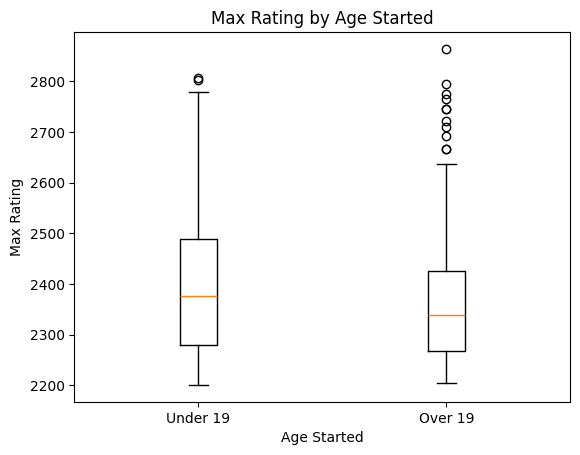

In [22]:
kids = players[players['Age Started'] <= timedelta(19*365)].dropna()
adults = players[players['Age Started'] > timedelta(19*365)].dropna()
kids = kids[kids.notna()]
adults = adults[adults.notna()]

plt.boxplot([kids['Max Rating'], adults['Max Rating']], tick_labels=['Under 19', 'Over 19'])
plt.title('Max Rating by Age Started')
plt.xlabel('Age Started')
plt.ylabel('Max Rating')
plt.show()

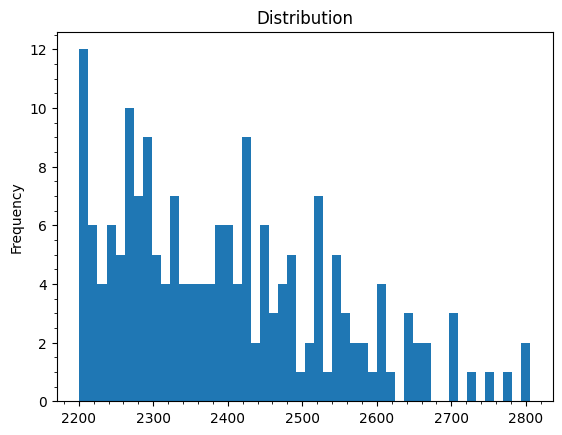

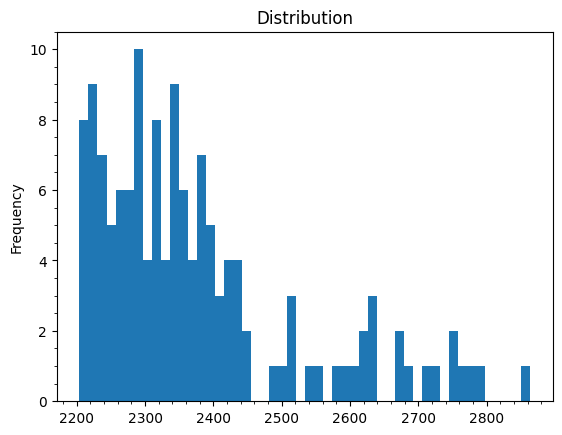

In [23]:
def plotDistribution(arr, bins=50):
    plt.title('Distribution')
    plt.hist(arr, bins=bins)
    plt.ylabel('Frequency')
    plt.minorticks_on()
    plt.show()

plotDistribution(kids['Max Rating'])
plotDistribution(adults['Max Rating'])